In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef,  accuracy_score, f1_score

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

### Uncensoring DT

In [2]:
#Step 1: set up data for DT

feature_cols = ["KSR_Anteil","TSR_Anteil","KSR_TSR_Anteil","data_sparsity",
                "laenge","stockout_rate","verkauf_variance","verkauf_mean","coefficient_of_variation","unique_quantities",
                "variance_to_mean_ratio","verkauf_autocorr","adi","censored_rate","censored_n"]
df = pd.read_csv('dt_inputs/Uncensoring_DT_Input.csv')
#df.dropna(subset=['Bayesian_POS_gini_coefficient', 'Agrawal_gini_coefficient'], inplace=True)
df.drop(['Gesamtzeilen','KSR_Count','TSR_Count','KSR_TSR_Summe'], axis='columns', inplace=True)
print(f"{df.isnull().any(axis=1).sum()} rows with missing values")
print(f"{df[['Bayesian_POS_gini_coefficient', 'Agrawal_gini_coefficient']].isna().any(axis=1).sum()} rows with missing gini coef")
methods = ['N1', 'N2', 'N3', 'EM', 'PD', 'Conrad', 'Nahmias', 'Bayesian_POS', 'Baseline', 'Agrawal']

X = df[feature_cols]
y = df['best_method_weighted_mae_0']

print(y.value_counts())


399 rows with missing values
399 rows with missing gini coef
best_method_weighted_mae_0
N3          3796
Bayesian    1672
PD          1547
Conrad      1176
EM           845
Nahmias      824
Agrawal      468
Baseline     294
N1            47
N2            16
Name: count, dtype: int64


In [3]:
#Step 2: Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_counts = Counter(y_train)
print(y_train.value_counts())

best_method_weighted_mae_0
N3          3054
Bayesian    1310
PD          1258
Conrad       916
EM           682
Nahmias      645
Agrawal      390
Baseline     240
N1            42
N2            11
Name: count, dtype: int64


In [123]:
#Step 3: resample training set

small_classes = [cls for cls, count in y_counts.items() if count < 6]
majority_class = max(y_counts, key=y_counts.get)
random_sampling_strategy = {cls: 6 for cls in small_classes} #for groups with < 6 items, use random sampling to increase size to 6
under_sampling_strategy = {majority_class: 2000} #use random undersampling on majority class to reduce
sampler = Pipeline(steps=[
    ('under', RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=42)),
    ('random', RandomOverSampler(sampling_strategy=random_sampling_strategy, random_state=42)),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42))
])

X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
print('after resampling:')
print(y_train_resampled.value_counts())

after resampling:
best_method_weighted_mae_0
Agrawal     2000
Baseline    2000
Bayesian    2000
Conrad      2000
EM          2000
N1          2000
N2          2000
N3          2000
Nahmias     2000
PD          2000
Name: count, dtype: int64


In [4]:
#Step 4: hyperparameter tuning

max_depth = [4,6,8,10]
min_samples_leaf = [1, 20, 40]
criterion = ['gini', 'entropy', 'log_loss']
for md in max_depth:
    for c in criterion:
        clf = DecisionTreeClassifier(random_state=42,max_depth=md, criterion=c, min_samples_leaf=1)
        # clf.fit(X_train_resampled, y_train_resampled)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        mcc = matthews_corrcoef(y_test, y_pred)

        print(f"max_depth={md}, criterion = {c}"
            f"-> Accuracy: {acc:.4f}, F1 (macro): {f1:.4f}, MCC: {mcc:.4f}")

max_depth=4, criterion = gini-> Accuracy: 0.5606, F1 (macro): 0.2965, MCC: 0.4653
max_depth=4, criterion = entropy-> Accuracy: 0.5662, F1 (macro): 0.2950, MCC: 0.4651
max_depth=4, criterion = log_loss-> Accuracy: 0.5662, F1 (macro): 0.2950, MCC: 0.4651
max_depth=6, criterion = gini-> Accuracy: 0.5793, F1 (macro): 0.3264, MCC: 0.4666
max_depth=6, criterion = entropy-> Accuracy: 0.5803, F1 (macro): 0.3498, MCC: 0.4669
max_depth=6, criterion = log_loss-> Accuracy: 0.5803, F1 (macro): 0.3498, MCC: 0.4669
max_depth=8, criterion = gini-> Accuracy: 0.5807, F1 (macro): 0.3537, MCC: 0.4689
max_depth=8, criterion = entropy-> Accuracy: 0.5704, F1 (macro): 0.3823, MCC: 0.4642
max_depth=8, criterion = log_loss-> Accuracy: 0.5704, F1 (macro): 0.3823, MCC: 0.4642
max_depth=10, criterion = gini-> Accuracy: 0.5573, F1 (macro): 0.3440, MCC: 0.4397
max_depth=10, criterion = entropy-> Accuracy: 0.5503, F1 (macro): 0.3680, MCC: 0.4358
max_depth=10, criterion = log_loss-> Accuracy: 0.5503, F1 (macro): 0.368

In [5]:
#Step 5: Train DT on best hyperparameters

clf = DecisionTreeClassifier(random_state=42,max_depth=8, criterion='gini', min_samples_leaf=1)
clf.fit(X_train_resampled, y_train_resampled)
#clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("matthew's correlation coef: ", matthews_corrcoef(y_test, y_pred))


NameError: name 'X_train_resampled' is not defined

In [6]:
#Step 6: Visualize results

# Method 1: Built-in Decision Tree Feature Importance

# Get feature importance from the trained decision tree
feature_importance = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier viewing
import pandas as pd
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance (Decision Tree):")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance)
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()
plt.show()

# Method 2: Permutation Importance (more reliable)
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# Create DataFrame
perm_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nPermutation Importance:")
print(perm_df)

# Plot permutation importance with error bars
plt.figure(figsize=(10, 6))
plt.barh(range(len(perm_importance.importances_mean)), perm_importance.importances_mean, xerr=perm_importance.importances_std)
plt.yticks(range(len(perm_importance.importances_mean)), feature_names)
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Method 3: Visualize the Decision Tree Structure
# from sklearn.tree import plot_tree
# plt.figure(figsize=(80, 40))
# plot_tree(clf, feature_names=feature_names, class_names=clf.classes_, filled=True, rounded=True)
# plt.title('Decision Tree Structure')
# plt.show()

# # Method 4: Export tree rules (text format)
# from sklearn.tree import export_text
# tree_rules = export_text(clf, feature_names=list(feature_names))
# print("\nDecision Tree Rules:")
# print(tree_rules)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Inventory DT

In [7]:
#Step 1: set up data for DT
df = pd.read_csv('dt_inputs/Sales_DT_Input.csv')
df.drop(['Gesamtzeilen','KSR_Count','TSR_Count','KSR_TSR_Summe'], axis='columns', inplace=True)
feature_cols = ["KSR_Anteil", "TSR_Anteil", "KSR_TSR_Anteil", "data_sparsity", "laenge",
                "stockout_rate", "verkauf_variance", "verkauf_mean", "coefficient_of_variation", "unique_quantities", 'variance_to_mean_ratio',
                "verkauf_autocorr", "adi", "censored_rate", "censored_n"]
df = df[df['laenge']>1] #so we have variance values for all points
#df = df[df['verkauf_mean']>=1]

print(f"{df.isna().any(axis=1).sum()} rows with missing values")
print(f"{df[feature_cols].isna().any(axis=1).sum()} rows with missing feature values")
print(f"{df[['Bayesian_POS_pinball_loss']].isna().any(axis=1).sum()} rows with missing Bayesian results")
print(f"{df[['Agrawal_pinball_loss']].isna().any(axis=1).sum()} rows with missing Agrawal results")
print(f"{df[['Bayesian_POS_pinball_loss', 'Agrawal_pinball_loss']].isna().any(axis=1).sum()} rows with missing Agrawal or Bayesian results")
#remaining ~1000 missing is because bayesian sometimes doesn't have beta fill rate

methods = ['N1', 'N2', 'N3', 'EM', 'PD', 'Conrad', 'Nahmias', 'Bayesian_POS', 'Baseline', 'Agrawal']

X = df[feature_cols]
y = df['best_method_pinball_loss']
print(y.value_counts())


7005 rows with missing values
0 rows with missing feature values
5797 rows with missing Bayesian results
5083 rows with missing Agrawal results
5797 rows with missing Agrawal or Bayesian results
best_method_pinball_loss
Baseline    9191
Conrad      8010
N1           850
Bayesian     809
Nahmias      790
Agrawal      363
EM           152
N2            68
PD             5
N3             2
Name: count, dtype: int64


In [8]:
#Step 2: Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_counts = Counter(y_train)
print(y_train.value_counts())

best_method_pinball_loss
Baseline    7370
Conrad      6425
N1           683
Nahmias      625
Bayesian     624
Agrawal      284
EM           118
N2            57
PD             5
N3             1
Name: count, dtype: int64


In [9]:
#Step 3: resample training set

small_classes = [cls for cls, count in y_counts.items() if count < 6]
majority_class = max(y_counts, key=y_counts.get)
random_sampling_strategy = {cls: 6 for cls in small_classes} #for groups with < 6 items, use random sampling to increase size to 6
under_sampling_strategy = {'Baseline': 6000, 'Conrad': 6000} #use random undersampling on majority class to reduce
sampler = Pipeline(steps=[
    ('under', RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=42)),
    ('random', RandomOverSampler(sampling_strategy=random_sampling_strategy, random_state=42)),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42))
])

X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
print('after resampling:')
print(y_train_resampled.value_counts())

after resampling:
best_method_pinball_loss
Agrawal     6000
Baseline    6000
Bayesian    6000
Conrad      6000
EM          6000
N1          6000
N2          6000
N3          6000
Nahmias     6000
PD          6000
Name: count, dtype: int64


In [10]:
#Step 4: hyperparameter tuning

max_depth = [4]
min_samples_leaf = [1, 20, 40]
criterion = ['entropy', 'gini', 'log_loss']
for md in max_depth:
    for c in criterion:
        clf = DecisionTreeClassifier(random_state=42,max_depth=md, criterion=c, min_samples_leaf=1)
        clf.fit(X_train_resampled, y_train_resampled)
        #clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        mcc = matthews_corrcoef(y_test, y_pred)

        print(f"max_depth={md}, criterion = {c}"
            f"-> Accuracy: {acc:.4f}, F1 (macro): {f1:.4f}, MCC: {mcc:.4f}")

max_depth=4, criterion = entropy-> Accuracy: 0.2458, F1 (macro): 0.1374, MCC: 0.1525
max_depth=4, criterion = gini-> Accuracy: 0.2399, F1 (macro): 0.1136, MCC: 0.1467
max_depth=4, criterion = log_loss-> Accuracy: 0.2458, F1 (macro): 0.1374, MCC: 0.1525


In [11]:
#Step 5: Train DT on best hyperparameters

clf = DecisionTreeClassifier(random_state=42,max_depth=4, criterion='gini', min_samples_leaf=1)
clf.fit(X_train_resampled, y_train_resampled)
#clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("matthew's correlation coef: ", matthews_corrcoef(y_test, y_pred))

              precision    recall  f1-score   support

     Agrawal       0.25      0.71      0.37        79
    Baseline       0.70      0.46      0.56      1821
    Bayesian       0.00      0.00      0.00       185
      Conrad       0.90      0.01      0.02      1585
          EM       0.04      0.97      0.07        34
          N1       0.00      0.00      0.00       167
          N2       0.00      0.64      0.01        11
          N3       0.00      0.00      0.00         1
     Nahmias       0.12      0.10      0.11       165
          PD       0.00      0.00      0.00         0

    accuracy                           0.24      4048
   macro avg       0.20      0.29      0.11      4048
weighted avg       0.68      0.24      0.27      4048

matthew's correlation coef:  0.14668954366908238


/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/env

Feature Importance (Decision Tree):
                     feature  importance
9          unique_quantities    0.428283
7               verkauf_mean    0.260201
3              data_sparsity    0.162437
0                 KSR_Anteil    0.075897
5              stockout_rate    0.053765
12                       adi    0.012384
6           verkauf_variance    0.005598
4                     laenge    0.001044
10    variance_to_mean_ratio    0.000390
1                 TSR_Anteil    0.000000
2             KSR_TSR_Anteil    0.000000
8   coefficient_of_variation    0.000000
11          verkauf_autocorr    0.000000
13             censored_rate    0.000000
14                censored_n    0.000000


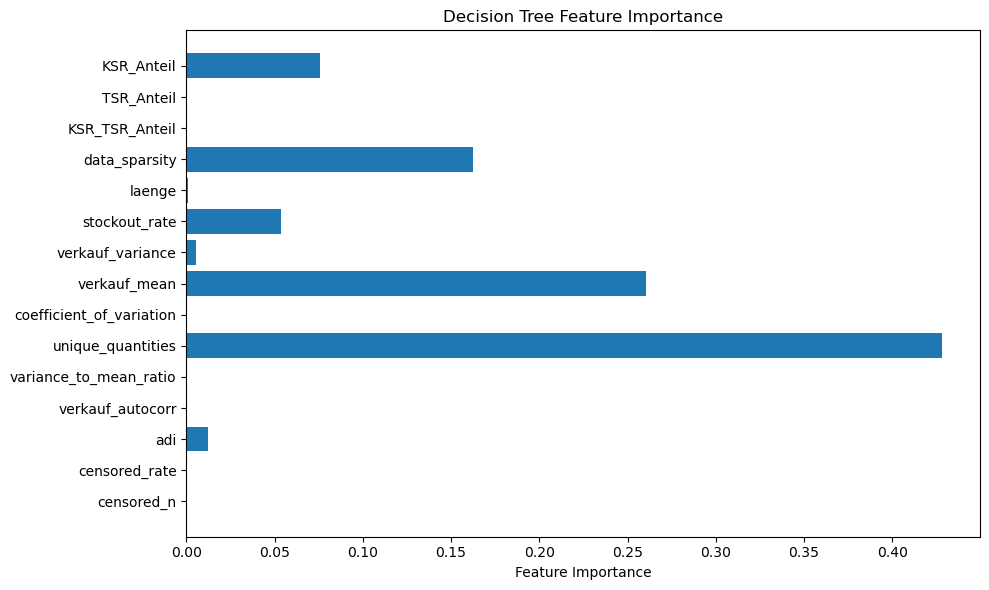


Permutation Importance:
                     feature  importance_mean  importance_std
3              data_sparsity         0.071171        0.002329
5              stockout_rate         0.066650        0.001900
9          unique_quantities         0.004817        0.002505
7               verkauf_mean         0.003780        0.000635
6           verkauf_variance         0.003162        0.000148
10    variance_to_mean_ratio         0.002964        0.000191
1                 TSR_Anteil         0.000000        0.000000
2             KSR_TSR_Anteil         0.000000        0.000000
4                     laenge         0.000000        0.000000
8   coefficient_of_variation         0.000000        0.000000
11          verkauf_autocorr         0.000000        0.000000
13             censored_rate         0.000000        0.000000
14                censored_n         0.000000        0.000000
12                       adi        -0.002841        0.000858
0                 KSR_Anteil        -0.006151

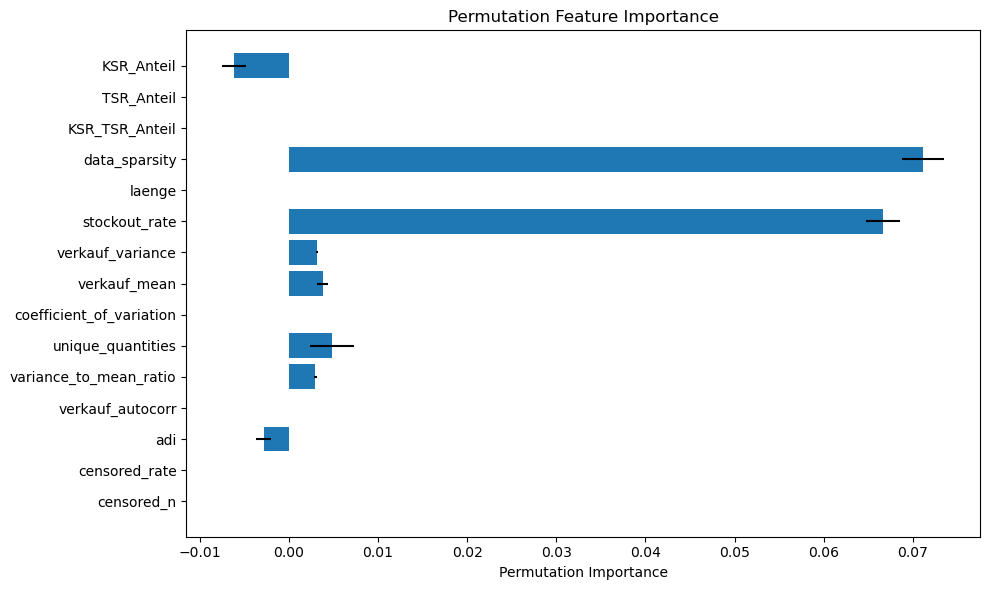

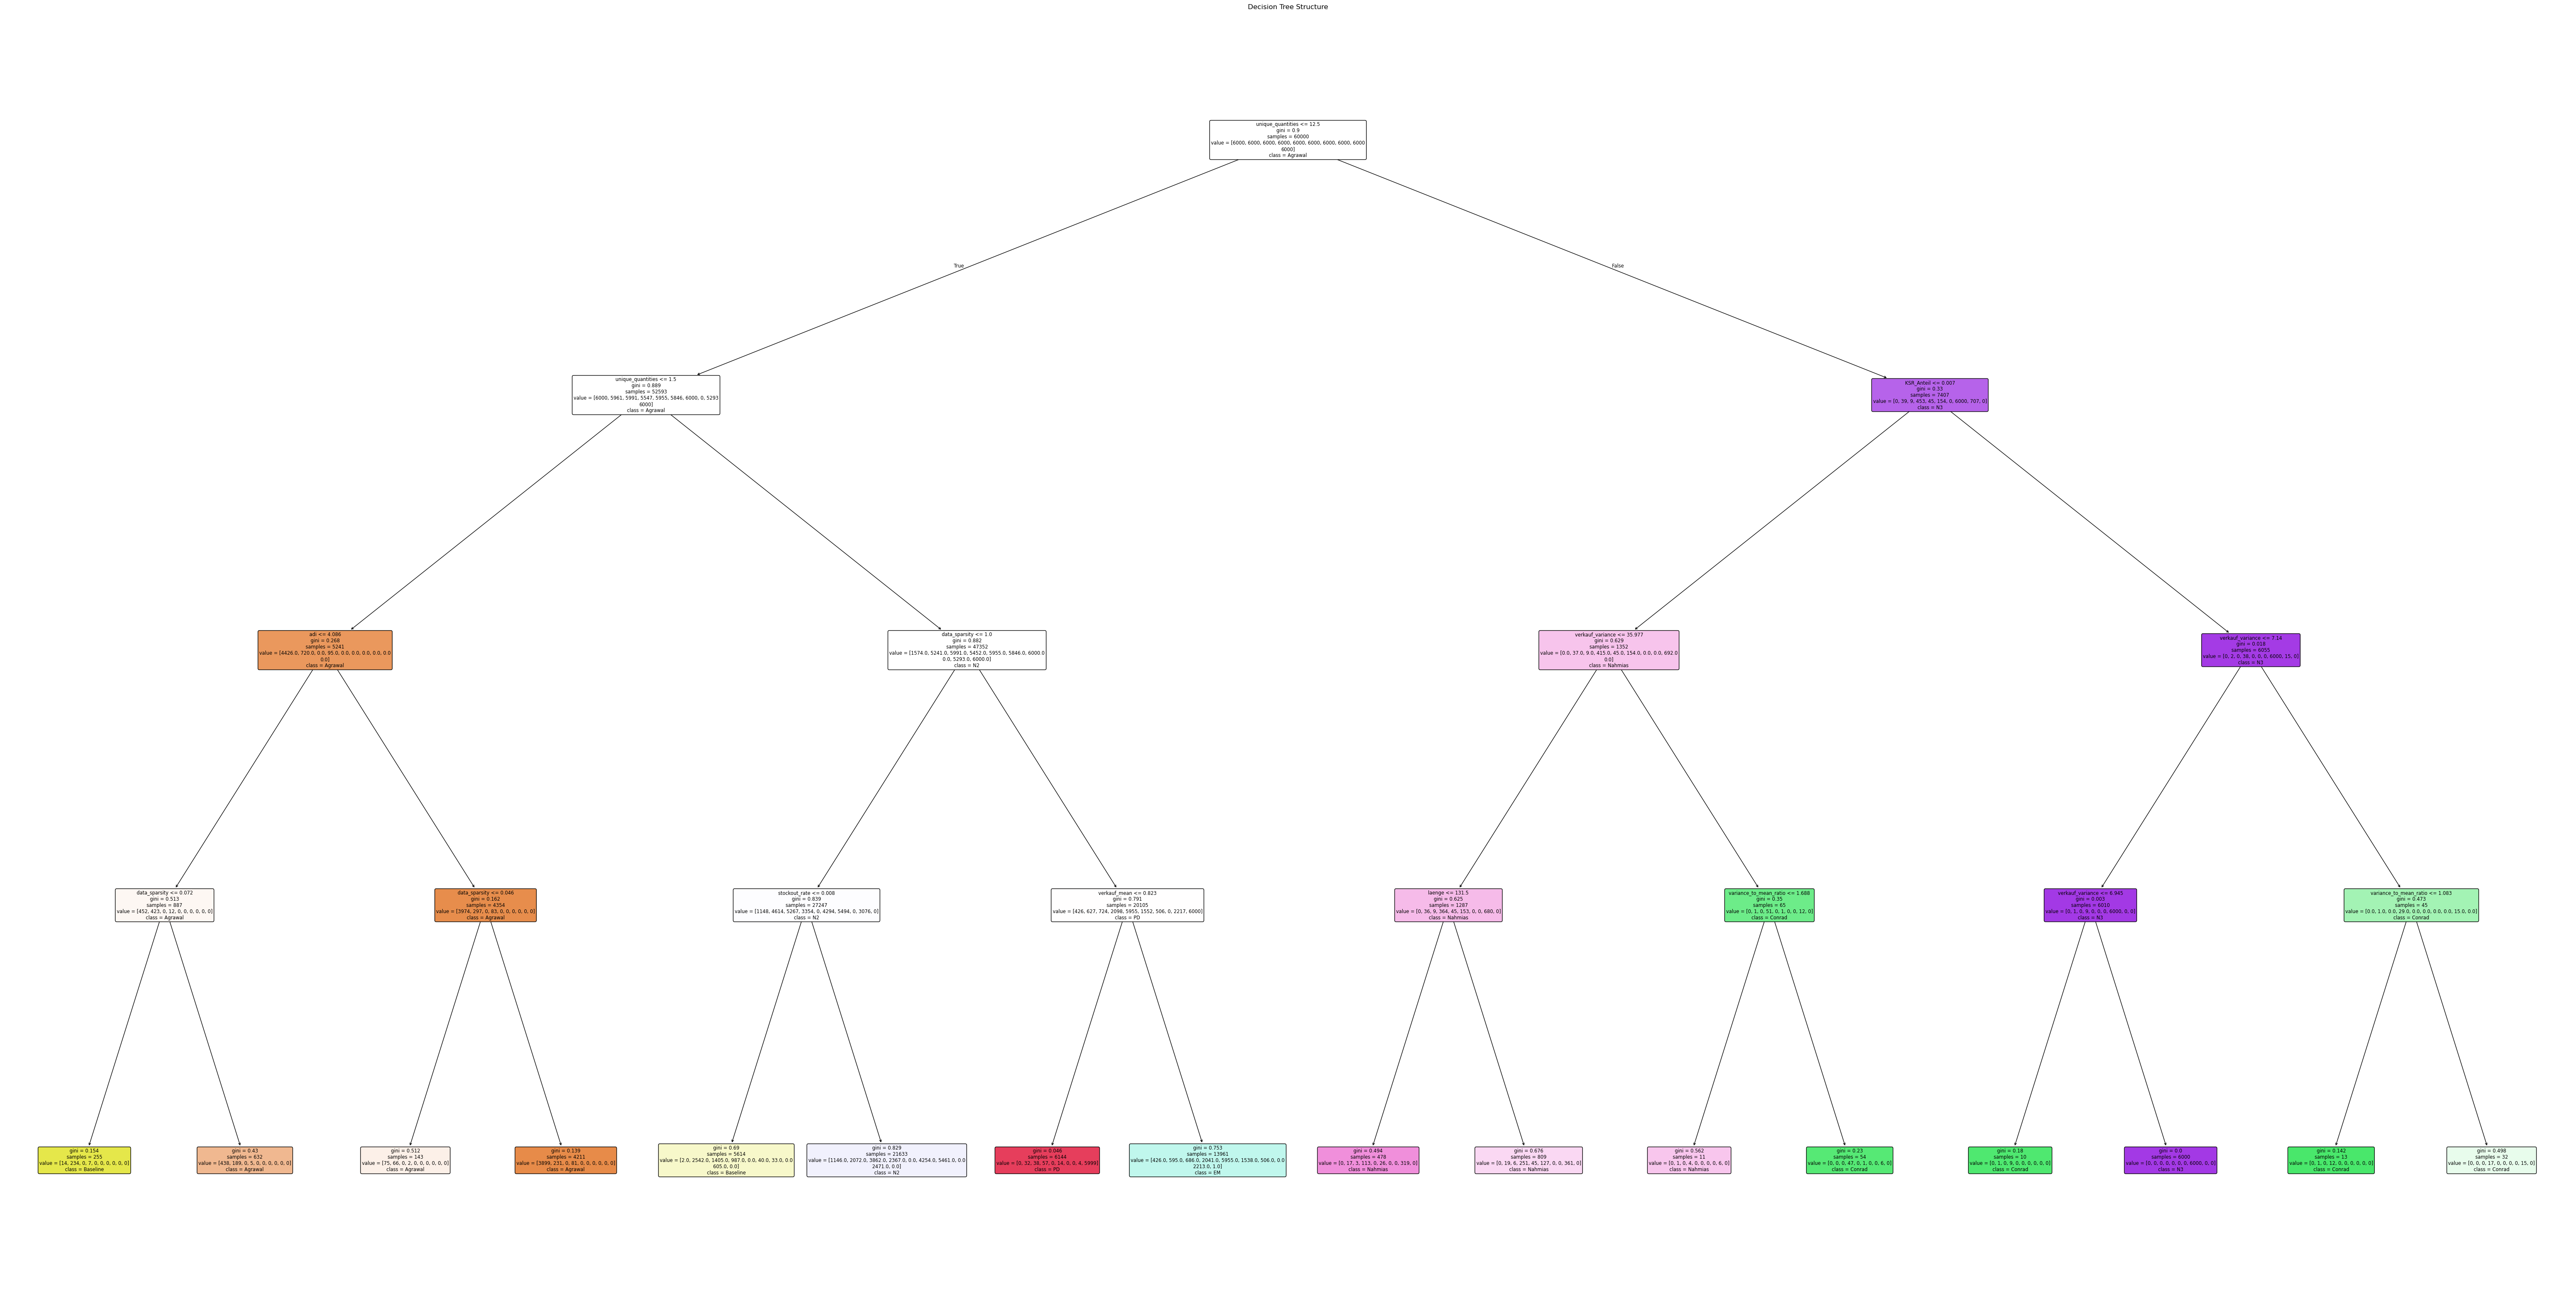


Decision Tree Rules:
|--- unique_quantities <= 12.50
|   |--- unique_quantities <= 1.50
|   |   |--- adi <= 4.09
|   |   |   |--- data_sparsity <= 0.07
|   |   |   |   |--- class: Baseline
|   |   |   |--- data_sparsity >  0.07
|   |   |   |   |--- class: Agrawal
|   |   |--- adi >  4.09
|   |   |   |--- data_sparsity <= 0.05
|   |   |   |   |--- class: Agrawal
|   |   |   |--- data_sparsity >  0.05
|   |   |   |   |--- class: Agrawal
|   |--- unique_quantities >  1.50
|   |   |--- data_sparsity <= 1.00
|   |   |   |--- stockout_rate <= 0.01
|   |   |   |   |--- class: Baseline
|   |   |   |--- stockout_rate >  0.01
|   |   |   |   |--- class: N2
|   |   |--- data_sparsity >  1.00
|   |   |   |--- verkauf_mean <= 0.82
|   |   |   |   |--- class: PD
|   |   |   |--- verkauf_mean >  0.82
|   |   |   |   |--- class: EM
|--- unique_quantities >  12.50
|   |--- KSR_Anteil <= 0.01
|   |   |--- verkauf_variance <= 35.98
|   |   |   |--- laenge <= 131.50
|   |   |   |   |--- class: Nahmias
| 

In [12]:
# Method 1: Built-in Decision Tree Feature Importance

# Get feature importance from the trained decision tree
feature_importance = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier viewing
import pandas as pd
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance (Decision Tree):")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance)
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()
plt.show()

# Method 2: Permutation Importance (more reliable)
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# Create DataFrame
perm_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nPermutation Importance:")
print(perm_df)

# Plot permutation importance with error bars
plt.figure(figsize=(10, 6))
plt.barh(range(len(perm_importance.importances_mean)), perm_importance.importances_mean, xerr=perm_importance.importances_std)
plt.yticks(range(len(perm_importance.importances_mean)), feature_names)
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Method 3: Visualize the Decision Tree Structure
from sklearn.tree import plot_tree
plt.figure(figsize=(80, 40))
plot_tree(clf, feature_names=feature_names, class_names=clf.classes_, filled=True, rounded=True)
plt.title('Decision Tree Structure')
plt.show()

# Method 4: Export tree rules (text format)
from sklearn.tree import export_text
tree_rules = export_text(clf, feature_names=list(feature_names))
print("\nDecision Tree Rules:")
print(tree_rules)

### Re-evaluate KPI

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef

def analyze_uncensoring_methods(csv_file_path, metric_name, max_depth=4, test_size=0.2, random_state=42):
    """
    Complete analysis pipeline for uncensoring method selection using decision trees.
    
    Parameters:
    -----------
    csv_file_path : str
        Path to the CSV file containing the uncensoring data
    metric_name : str
        The metric to use for finding the best method (e.g., 'weighted_mae_0', 'accuracy', 'mse', etc.)
    max_depth : int, default=4
        Maximum depth of the decision tree
    test_size : float, default=0.2
        Proportion of dataset to include in the test split
    random_state : int, default=42
        Random state for reproducibility
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'classifier': Trained DecisionTreeClassifier
        - 'X_train', 'X_test', 'y_train', 'y_test': Train/test splits
        - 'y_pred': Predictions on test set
        - 'df': Full dataframe with best_method column
        - 'results': Dictionary with all evaluation metrics
    """
    
    # Read the data
    df = pd.read_csv(csv_file_path)
    
    # Define the methods
    methods = ['Bayesian_POS', 'N1', 'N2', 'N3', 'EM', 'PD', 'Nahmias', 'Conrad',
                'Baseline', 'Agrawal']
    
    # Create the column names for the specified metric
    metric_cols = [f"{method}_{metric_name}" for method in methods]
    
    # Check if all metric columns exist in the dataframe
    missing_cols = [col for col in metric_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in dataframe: {missing_cols}")
    
    # Find the best method for each row based on the metric
    # For metrics like MAE, MSE (lower is better), use idxmin
    # For metrics like accuracy (higher is better), use idxmax
    if any(keyword in metric_name.lower() for keyword in ['mae', 'mse', 'error', 'loss']):
        df[f'best_method_{metric_name}'] = df[metric_cols].idxmin(axis=1)
        optimization_direction = "minimize"
    else:
        # For accuracy and similar metrics where higher is better
        df[f'best_method_{metric_name}'] = df[metric_cols].idxmax(axis=1)
        optimization_direction = "maximize"
    
    # Map the column names back to method names
    col_to_method_map = {f"{method}_{metric_name}": method for method in methods}
    df[f'best_method_{metric_name}'] = df[f'best_method_{metric_name}'].map(col_to_method_map)
    
    # Define feature columns
    feature_cols = ["KSR_Anteil", "TSR_Anteil", "KSR_TSR_Anteil", "data_sparsity", "laenge",
                    "stockout_rate", "verkauf_variance", "verkauf_mean", "coefficient_of_variation", "unique_quantities", 'variance_to_mean_ratio',
                    "verkauf_autocorr", "adi", "censored_rate", "censored_n"]
    
    # Check if all feature columns exist
    missing_features = [col for col in feature_cols if col not in df.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns in dataframe: {missing_features}")
    
    # Prepare X and y
    X = df[feature_cols]
    y = df[f'best_method_{metric_name}']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize and train the classifier
    clf = DecisionTreeClassifier(random_state=random_state, max_depth=max_depth)
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # ============================================================================
    # Evaluation and Analysis
    # ============================================================================
    
    print(f"UNCENSORING METHOD ANALYSIS - {metric_name.upper()}")
    print("="*80)
    print(f"Dataset: {csv_file_path}")
    print(f"Metric: {metric_name} ({optimization_direction})")
    print(f"Sample size: {len(df)} observations")
    print(f"Train/Test split: {len(X_train)}/{len(X_test)}")
    
    print(f"\nCLASSIFICATION PERFORMANCE")
    print("="*80)
    print(classification_report(y_test, y_pred))
    
    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    # MCC interpretation
    if mcc > 0.8:
        interpretation = "Very Strong"
    elif mcc > 0.6:
        interpretation = "Strong" 
    elif mcc > 0.4:
        interpretation = "Moderate"
    elif mcc > 0.2:
        interpretation = "Weak"
    elif mcc > 0:
        interpretation = "Very Weak"
    elif mcc == 0:
        interpretation = "No Correlation"
    else:
        interpretation = "Negative Correlation"
    
    print(f"Correlation Strength: {interpretation}")
    
    # ============================================================================
    # Metric-based Evaluation
    # ============================================================================
    
    print(f"\n{metric_name.upper()} COMPARISON RESULTS")
    print("="*80)
    
    # Get the test set indices to align with original dataframe
    test_indices = X_test.index
    
    # 1. Perfect Strategy (Oracle): Always pick the best method
    perfect_metric_values = []
    for idx in test_indices:
        best_method = df.loc[idx, f'best_method_{metric_name}']
        best_metric_value = df.loc[idx, best_method + f'_{metric_name}']
        perfect_metric_values.append(best_metric_value)
    perfect_avg_metric = np.mean(perfect_metric_values)
    
    # 2. Decision Tree Strategy: Use classifier predictions
    dt_metric_values = []
    for i, idx in enumerate(test_indices):
        predicted_method = y_pred[i]
        predicted_metric_value = df.loc[idx, predicted_method + f'_{metric_name}']
        dt_metric_values.append(predicted_metric_value)
    dt_avg_metric = np.mean(dt_metric_values)
    
    # 3. Most Common Method Strategy
    most_common_method = y_train.mode()[0]  # Use training set to determine most common
    common_metric_values = []
    for idx in test_indices:
        common_metric_value = df.loc[idx, most_common_method + f'_{metric_name}']
        common_metric_values.append(common_metric_value)
    common_avg_metric = np.mean(common_metric_values)
    
    # 4. Best Overall Method Strategy (best average metric across all data)
    # Calculate average metric for each method across all data
    method_avg_metrics = {}
    for method in methods:
        method_avg_metrics[method] = df[method + f'_{metric_name}'].mean()
    
    if optimization_direction == "minimize":
        best_overall_method = min(method_avg_metrics, key=method_avg_metrics.get)
    else:
        best_overall_method = max(method_avg_metrics, key=method_avg_metrics.get)
    
    best_overall_metric_values = []
    for idx in test_indices:
        best_overall_metric_value = df.loc[idx, best_overall_method + f'_{metric_name}']
        best_overall_metric_values.append(best_overall_metric_value)
    best_overall_avg_metric = np.mean(best_overall_metric_values)
    
    # Print results
    print(f"1. Perfect Strategy (Oracle):        {perfect_avg_metric:.6f}")
    print(f"2. Decision Tree Classifier:         {dt_avg_metric:.6f}")
    print(f"3. Most Common Method ({most_common_method}):  {common_avg_metric:.6f}")
    print(f"4. Best Overall Method ({best_overall_method}):      {best_overall_avg_metric:.6f}")
    
    # ============================================================================
    # Performance Analysis
    # ============================================================================
    
    print(f"\nPERFORMACE ANALYSIS")
    print("="*80)
    
    if optimization_direction == "minimize":
        # For metrics where lower is better
        dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
        dt_vs_common = (common_avg_metric / dt_avg_metric - 1) * 100
        dt_vs_best_overall = (best_overall_avg_metric / dt_avg_metric - 1) * 100
        
        print(f"Decision Tree vs Perfect:            +{dt_vs_perfect:.2f}% worse")
        print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
        print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
    else:
        # For metrics where higher is better
        dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
        dt_vs_common = (dt_avg_metric / common_avg_metric - 1) * 100
        dt_vs_best_overall = (dt_avg_metric / best_overall_avg_metric - 1) * 100
        
        print(f"Decision Tree vs Perfect:            {dt_vs_perfect:.2f}% worse")
        print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
        print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
    
    # ============================================================================
    # Method Distribution Analysis
    # ============================================================================
    
    print(f"\nMETHOD SELECTION FREQUENCY (Test Set)")
    print("="*80)
    print("Decision Tree Predictions:")
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    for method, count in pred_counts.items():
        print(f"  {method}: {count} ({count/len(y_pred)*100:.1f}%)")
    
    print(f"\nActual Best Methods:")
    actual_counts = y_test.value_counts().sort_index()
    for method, count in actual_counts.items():
        print(f"  {method}: {count} ({count/len(y_test)*100:.1f}%)")
    
    print(f"\nOverall Method Performance (Average {metric_name} across all data):")
    print("="*80)
    if optimization_direction == "minimize":
        sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1])
    else:
        sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1], reverse=True)
    
    for method, avg_metric in sorted_methods:
        print(f"  {method}: {avg_metric:.6f}")
    
    # Decision tree accuracy in terms of picking the exact best method
    exact_matches = sum(y_pred == y_test)
    accuracy = exact_matches / len(y_test)
    print(f"\nDecision Tree Accuracy (Exact Best Method): {accuracy:.3f} ({exact_matches}/{len(y_test)})")
    
    # Prepare results dictionary
    results = {
        'perfect_avg_metric': perfect_avg_metric,
        'dt_avg_metric': dt_avg_metric,
        'common_avg_metric': common_avg_metric,
        'best_overall_avg_metric': best_overall_avg_metric,
        'most_common_method': most_common_method,
        'best_overall_method': best_overall_method,
        'mcc': mcc,
        'accuracy': accuracy,
        'method_avg_metrics': method_avg_metrics,
        'optimization_direction': optimization_direction
    }
    
    return {
        'classifier': clf,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'df': df,
        'results': results
    }

In [ ]:
import pandas as pd
import numpy as np
# ============================================================================
# Metric-based Evaluation
# ============================================================================
metric_name = 'weighted_mae_0'
optimization_direction = "minimize"
df = pd.read_csv('dt_inputs/Uncensoring_DT_Input.csv')

methods = ['Bayesian', 'N1', 'N2', 'N3', 'EM', 'PD', 'Nahmias', 'Conrad',
                'Baseline', 'Agrawal']
print(f"\n{metric_name.upper()} COMPARISON RESULTS")
print("="*80)

# Get the test set indices to align with original dataframe
test_indices = X_test.index

# 1. Perfect Strategy (Oracle): Always pick the best method
perfect_metric_values = []
for idx in test_indices:
    best_method = df.loc[idx, f'best_method_{metric_name}']
    if best_method == 'Bayesian': best_method = 'Bayesian_POS'
    best_metric_value = df.loc[idx, best_method + f'_{metric_name}']
    perfect_metric_values.append(best_metric_value)
perfect_avg_metric = np.mean(perfect_metric_values)

# 2. Decision Tree Strategy: Use classifier predictions
dt_metric_values = []
for i, idx in enumerate(test_indices):
    predicted_method = y_pred[i]
    #predicted_method = clf.predict(X_test.loc[[idx]])[0]
    if predicted_method == 'Bayesian': predicted_method = 'Bayesian_POS'
    predicted_metric_value = df.loc[idx, predicted_method + f'_{metric_name}']
    dt_metric_values.append(predicted_metric_value)
dt_avg_metric = np.mean(dt_metric_values)

# 3. Most Common Method Strategy
most_common_method = y_train.mode()[0]  # Use training set to determine most common
if most_common_method == 'Bayesian': most_common_method = 'Bayesian_POS'
common_metric_values = []
for idx in test_indices:
    common_metric_value = df.loc[idx, most_common_method + f'_{metric_name}']
    common_metric_values.append(common_metric_value)
common_avg_metric = np.mean(common_metric_values)

# 4. Best Overall Method Strategy (best average metric across all data)
# Calculate average metric for each method across all data
method_avg_metrics = {}
for method in methods:
    if method == 'Bayesian': method = 'Bayesian_POS'
    method_avg_metrics[method] = df[method + f'_{metric_name}'].mean()

best_overall_method = min(method_avg_metrics, key=method_avg_metrics.get)
if best_overall_method == 'Bayesian': best_overall_method = 'Bayesian_POS'

best_overall_metric_values = []
for idx in test_indices:
    best_overall_metric_value = df.loc[idx, best_overall_method + f'_{metric_name}']
    best_overall_metric_values.append(best_overall_metric_value)
best_overall_avg_metric = np.mean(best_overall_metric_values)

# Print results
print(f"1. Perfect Strategy (Oracle):        {perfect_avg_metric:.6f}")
print(f"2. Decision Tree Classifier:         {dt_avg_metric:.6f}")
print(f"3. Most Common Method ({most_common_method}):  {common_avg_metric:.6f}")
print(f"4. Best Overall Method ({best_overall_method}):      {best_overall_avg_metric:.6f}")

# ============================================================================
# Performance Analysis
# ============================================================================

print(f"\nPERFORMACE ANALYSIS")
print("="*80)

# For metrics where lower is better
dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
dt_vs_common = (common_avg_metric / dt_avg_metric - 1) * 100
dt_vs_best_overall = (best_overall_avg_metric / dt_avg_metric - 1) * 100

print(f"Decision Tree vs Perfect:            +{dt_vs_perfect:.2f}% worse")
print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
# ============================================================================
# Method Distribution Analysis
# ============================================================================

print(f"\nMETHOD SELECTION FREQUENCY (Test Set)")
print("="*80)
print("Decision Tree Predictions:")
pred_counts = pd.Series(y_pred).value_counts().sort_index()
for method, count in pred_counts.items():
    print(f"  {method}: {count} ({count/len(y_pred)*100:.1f}%)")

print(f"\nActual Best Methods:")
actual_counts = y_test.value_counts().sort_index()
for method, count in actual_counts.items():
    print(f"  {method}: {count} ({count/len(y_test)*100:.1f}%)")

print(f"\nOverall Method Performance (Average {metric_name} across all data):")
print("="*80)
if optimization_direction == "minimize":
    sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1])
else:
    sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1], reverse=True)

for method, avg_metric in sorted_methods:
    print(f"  {method}: {avg_metric:.6f}")

# Decision tree accuracy in terms of picking the exact best method
exact_matches = sum(y_pred == y_test)
accuracy = exact_matches / len(y_test)
print(f"\nDecision Tree Accuracy (Exact Best Method): {accuracy:.3f} ({exact_matches}/{len(y_test)})")

# Prepare results dictionary
results = {
    'perfect_avg_metric': perfect_avg_metric,
    'dt_avg_metric': dt_avg_metric,
    'common_avg_metric': common_avg_metric,
    'best_overall_avg_metric': best_overall_avg_metric,
    'most_common_method': most_common_method,
    'best_overall_method': best_overall_method,
    'mcc': mcc,
    'accuracy': accuracy,
    'method_avg_metrics': method_avg_metrics,
    'optimization_direction': optimization_direction
}


WEIGHTED_MAE_0 COMPARISON RESULTS
1. Perfect Strategy (Oracle):        0.534369
2. Decision Tree Classifier:         0.666985
3. Most Common Method (N3):  0.790657
4. Best Overall Method (Baseline):      0.783578

PERFORMACE ANALYSIS
Decision Tree vs Perfect:            +24.82% worse
Decision Tree vs Most Common:        +18.54% better
Decision Tree vs Best Overall:       +17.48% better

METHOD SELECTION FREQUENCY (Test Set)
Decision Tree Predictions:
  Agrawal: 172 (8.0%)
  Baseline: 218 (10.2%)
  Bayesian: 554 (25.9%)
  Conrad: 126 (5.9%)
  EM: 212 (9.9%)
  N1: 91 (4.3%)
  N2: 29 (1.4%)
  N3: 391 (18.3%)
  Nahmias: 100 (4.7%)
  PD: 244 (11.4%)

Actual Best Methods:
  Agrawal: 78 (3.6%)
  Baseline: 54 (2.5%)
  Bayesian: 362 (16.9%)
  Conrad: 260 (12.2%)
  EM: 163 (7.6%)
  N1: 5 (0.2%)
  N2: 5 (0.2%)
  N3: 742 (34.7%)
  Nahmias: 179 (8.4%)
  PD: 289 (13.5%)

Overall Method Performance (Average weighted_mae_0 across all data):
  Baseline: 0.791220
  N3: 0.796324
  Nahmias: 0.800467
  PD

In [ ]:
# Usage
analysis = analyze_uncensoring_methods(
    csv_file_path='Best/Uncensoring_DT_Input copy.csv',
    metric_name='weighted_mae_0',
    max_depth=7 # Different hyperparameters
)

# Access results
mae_classifier = analysis['classifier']
mae_results = analysis['results']